# 利用LSTM进行汇率的预测

## 1.给定货币名称和货币在周1-周3的汇率，预测货币周4-周5的货币汇率

In [110]:
# 划分数据集

import numpy as np
import pandas as pd
from datetime import datetime

forex_file = 'forex.csv'
data = pd.read_csv(forex_file)  # slug, data, open, high, low, close, currency

# （相对日期，open1, high1, low1, close1, open2, high2, low2, close2, open3, high3, low3, close3)
# target: (open4, high4, low4, close4, open5, high5, low5, close5)
currency_convert_types = list(set(data['slug']))
currency_types = set()
for line in data['slug']:
    currency_types.add(line.split('/')[0])
    currency_types.add(line.split('/')[1])
currency_types = list(currency_types)

In [111]:
def date2weekday(date):  # return [0-6] as weekday
    date = datetime.strptime(date, '%Y-%m-%d')
    weekday = datetime.weekday(date)
    return weekday 

currency_convert_type = currency_convert_types[0]

week_datas = [[]]
start_weekday_0 = -1
for slug, date, open, high, low, close in zip(data['slug'], data['date'], data['open'], data['high'], data['low'], data['close']):
    if slug == currency_convert_type:
        weekday = date2weekday(date)
        if weekday == 0:
            week_datas.append([])
            if start_weekday_0 == -1:
                start_weekday_0 = datetime.strptime(date, '%Y-%m-%d')  # 记录最开始的周一

        date_order = (datetime.strptime(date, '%Y-%m-%d') - start_weekday_0).days
        date_order = float(date_order)
        week_datas[-1].append([date_order, open, high, low, close])

week_datas_proc = []
for week_data in week_datas:
    if len(week_data) == 5:  # 只保留完整的5天
        week_datas_proc.append(week_data)

print(f"共有{len(week_datas_proc)}个星期的数据")

共有869个星期的数据


In [112]:
# 使用LSTM进行预测
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class LSTM(nn.Module):
    def __init__(self, in_features, hid_dim, num_classes):
        super(LSTM, self).__init__()
        self.lin = nn.Linear(in_features, hid_dim)
        self.lstm = nn.LSTM(hid_dim, hid_dim, batch_first=True)
        self.regression = nn.Linear(hid_dim, num_classes)

    def forward(self, x):
        x = self.lin(x)
        _, (h_n, c_n) = self.lstm(x)
        out = h_n.squeeze(0)
        out = self.regression(out)
        return out
    
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {
                'x': self.data[idx][:3],
                'y': self.data[idx][3:][:,1:].reshape(-1)}
    
from sklearn.model_selection import train_test_split as tts

# 对所有数据进行归一化
week_datas_proc = torch.tensor(week_datas_proc)

train_data, test_data = tts(week_datas_proc, test_size=0.5, random_state=1234)
print(f'train:{len(train_data)}, test:{len(test_data)}')
train_set = MyDataset(train_data)
test_set = MyDataset(test_data)

train_loader = DataLoader(train_set, batch_size = 10)
test_loader = DataLoader(test_set, batch_size = 10)

train:434, test:435


In [113]:
# 定义模型训练
from torch.optim import Adam

max_patience = 20
patience = max_patience
in_features = 5
hid_dim = 128
num_classes = 8
epochs = 500
lr = 1e-5
model = LSTM(in_features, hid_dim, num_classes)
optimizer = Adam(model.parameters(), lr)
loss_f = torch.nn.MSELoss()

mus, sigmas = [], []
for i in range(week_datas_proc.shape[-1]):
    mu = torch.mean(week_datas_proc[:,:,i])
    sigma = torch.std(week_datas_proc[:,:,i])
    mus.append(mu)
    sigmas.append(sigma)

def norm_x(x):
    x = x.clone()
    for i in range(5):
        # x[:,:,i] = (x[:,:,i] - mus[i]) / sigmas[i]
        x[:,:,i] = (x[:,:,i] - mus[i])
    return x

def norm_y(y):
    y = y.clone().reshape(-1,2,4)
    for i in range(4):
        # y[:,:,i] = (y[:,:,i] - mus[i+1]) / sigmas[i+1]
        y[:,:,i] = y[:,:,i] - mus[i+1]
    return y.reshape(-1,8)

def unnorm_y(y):
    y = y.clone().reshape(-1,2,4)
    for i in range(4):
        y[:,:,i] = y[:,:,i] + mus[i+1]
    return y

min_test_loss = 1e10
for epoch in range(epochs):
    model.train()  # 训练模型
    train_loss = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        x, y = batch_data['x'], batch_data['y']
        x = norm_x(x)
        y = norm_y(y)
        out = model(x)
        loss = loss_f(out, y)
        loss.backward()
        train_loss += loss.item() * len(x)
        optimizer.step()
    train_loss /= len(train_loader.dataset)

    model.eval()  # 测试模型
    test_loss = 0
    for batch_data in test_loader:
        x, y = batch_data['x'], batch_data['y']
        x = norm_x(x)
        y = norm_y(y)
        with torch.no_grad():
            out = model(x)
        loss = loss_f(out, y)
        test_loss += loss.item() * len(x)
    test_loss /= len(test_loader.dataset)

    if test_loss < min_test_loss:
        min_test_loss = test_loss
        patience = max_patience
    else:
        patience -= 1
    print(f"epoch: {epoch:03}, train_loss: {train_loss:.5f}, test_loss: {test_loss:.5f}, patience: {patience}")
    if patience == 0:
        print("early stop")
        break

epoch: 000, train_loss: 0.06767, test_loss: 0.04371, patience: 20
epoch: 001, train_loss: 0.03751, test_loss: 0.02301, patience: 20
epoch: 002, train_loss: 0.01467, test_loss: 0.00981, patience: 20
epoch: 003, train_loss: 0.00756, test_loss: 0.00595, patience: 20
epoch: 004, train_loss: 0.00391, test_loss: 0.00270, patience: 20
epoch: 005, train_loss: 0.00180, test_loss: 0.00154, patience: 20
epoch: 006, train_loss: 0.00136, test_loss: 0.00118, patience: 20
epoch: 007, train_loss: 0.00105, test_loss: 0.00096, patience: 20
epoch: 008, train_loss: 0.00087, test_loss: 0.00081, patience: 20
epoch: 009, train_loss: 0.00073, test_loss: 0.00069, patience: 20
epoch: 010, train_loss: 0.00062, test_loss: 0.00060, patience: 20
epoch: 011, train_loss: 0.00055, test_loss: 0.00055, patience: 20
epoch: 012, train_loss: 0.00050, test_loss: 0.00050, patience: 20
epoch: 013, train_loss: 0.00045, test_loss: 0.00046, patience: 20
epoch: 014, train_loss: 0.00042, test_loss: 0.00042, patience: 20
epoch: 015

draw...


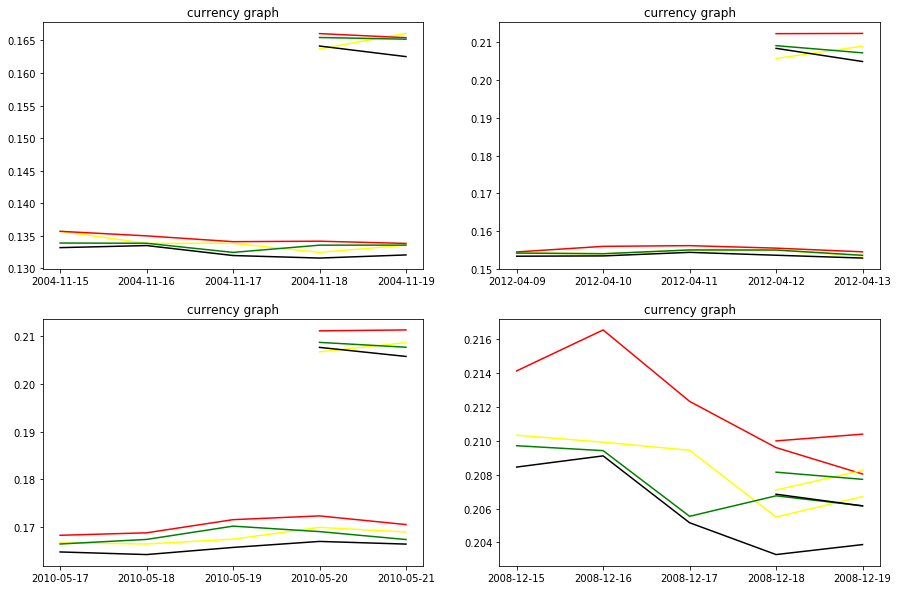

In [114]:
# 对测试数据进行还原
all_week_data = []

def next_n_days(date, n):  # 后n天的日期
    import datetime
    tmp = date + datetime.timedelta(n)
    return tmp

all_data = []
for batch_data in test_loader:
    x, y = batch_data['x'], batch_data['y']
    with torch.no_grad():
        out = model(x)
    out = unnorm_y(out)  # [week, 2, 4]
    x = x.tolist()
    y = y.reshape(-1,2,4).tolist()
    out = out.tolist()
    for prior_3, last_2, each_week_predict_data in zip(x, y, out):  # [星期，日期]
        weekday_0 = next_n_days(start_weekday_0, int(prior_3[0][0]))  # 星期一的日期
        weekday_4 = prior_3[0][0] + 3
        weekday_5 = prior_3[0][0] + 4
        last_2 = [[weekday_4] + last_2[0], [weekday_5] + last_2[1]]
        prior_3.extend(last_2)
        tmp_week_data = []  # 记录一周的数据
        for i in range(5):
            weekday_str = next_n_days(weekday_0, i).strftime('%Y-%m-%d')  # 字符串时间
            open, high, low, close = prior_3[i][1:]
            tmp_week_data.append([weekday_str, open, high, low, close])  # 一天的数据
        for i in range(2):
            weekday_str = next_n_days(weekday_0, i+3).strftime('%Y-%m-%d')  # 字符串时间
            open, high, low, close = each_week_predict_data[i]
            tmp_week_data.append([weekday_str, open, high, low, close])
        all_data.append(tmp_week_data)


# 任意选择 4 个星期进行画图
import random

week_idxes = []

print("draw...")
for i in range(4):
    idx = random.randint(0, len(all_data)-1)
    while idx in week_idxes:
        idx = random.randint(0, len(all_data)-1)
    week_idxes.append(idx)


import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
for i,week_idx in enumerate(week_idxes):
    ax = axs[i//2, i%2]
    single_week_data = all_data[week_idx]
    xs = [i for i in range(5)]
    opens, highs, lows, closes = [], [], [], []
    pred_opens, pred_highs, pred_lows, pred_closes = [], [], [], []

    for i in range(5):
        opens.append(single_week_data[i][1])
        highs.append(single_week_data[i][2])
        lows.append(single_week_data[i][3])
        closes.append(single_week_data[i][4])
    
    ax.set_title('currency graph')
    ax.set_xticks(xs)
    xtick_labels = [single_week_data[i][0] for i in range(5)]
    ax.set_xticklabels(xtick_labels)
    ax.plot(xs, opens, c='yellow', label='open')
    ax.plot(xs, highs, c='red', label='high')
    ax.plot(xs, lows, c='black', label='low')
    ax.plot(xs, closes, c='green', label='close')

    pred_xs = [3,4]
    ax.plot(pred_xs, [single_week_data[-2][1], single_week_data[-1][1]], c='yellow', label='pred_open')
    ax.plot(pred_xs, [single_week_data[-2][2], single_week_data[-1][2]], c='red', label='pred_high')
    ax.plot(pred_xs, [single_week_data[-2][3], single_week_data[-1][3]], c='black', label='pred_low')
    ax.plot(pred_xs, [single_week_data[-2][4], single_week_data[-1][4]], c='green', label='pred_close')
    # 设置x周标签
plt.show()


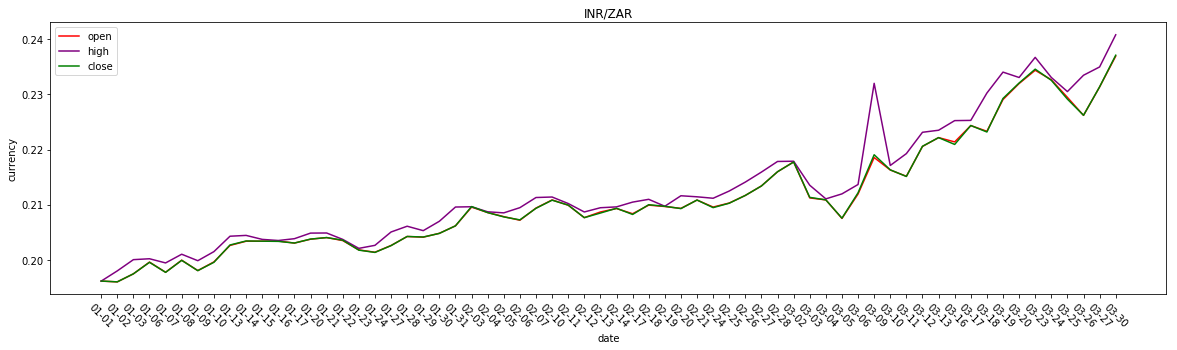

In [116]:
def date_later(d1, d2):
    import datetime
    return datetime.datetime.strptime(d1, '%Y-%m-%d') >= datetime.datetime.strptime(d2, '%Y-%m-%d')

def currency_vis(currency_convert_type, date_begin, date_end):
    import datetime
    x, y1, y2, y3, y4 = [], [], [], [], []
    for a, b, c, d, e, f in zip(data['date'], data['slug'], data['open'], data['high'], data['low'], data['close']):  # 选择两个月的数据进行可视化
        if b == currency_convert_type:
            if date_later(a, date_begin) and date_later(date_end, a):
                x.append(a[5:])
                y1.append(c)
                y2.append(d)
                y3.append(e)
                y4.append(f)

    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(x, y1, c='red', label='open')
    ax.plot(x, y2, c='purple', label='high')
    ax.plot(x, y3, c='black', label='low')
    ax.plot(x, y3, c='green', label='close')
    ax.set_title(currency_convert_type)
    ax.set_xlabel('date')
    ax.set_ylabel('currency')
    plt.xticks(rotation=-45)
    plt.legend()
    plt.show()

currency_vis(currency_convert_type, '2020-01-01', '2020-03-30')